In [ ]:
################################################################################
# Task 3: Forecast Future Market Trends with LSTM
################################################################################
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")

In [ ]:
tsla_close = pd.read_csv('../data/processed/tsla_close_prices.csv', parse_dates=True, index_col='Date')
lstm_model = joblib.load('../models/lstm_model.joblib')

In [ ]:
print("--- Step 1: Retraining the LSTM model on all available data ---")

# We will use the same model architecture as before.
# First, prepare the full dataset for training.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_full_data = scaler.fit_transform(tsla_close)

TIME_STEPS = 60 # Using the same time steps as before

def create_sequences(data, time_steps=TIME_STEPS):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

X_full, y_full = create_sequences(scaled_full_data)
X_full = np.reshape(X_full, (X_full.shape[0], X_full.shape[1], 1))

# Retrain the model on the full dataset
lstm_model.fit(X_full, y_full, batch_size=32, epochs=25, verbose=1)

--- Step 1: Retraining the LSTM model on all available data ---
Epoch 1/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0013
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.8509e-04
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5377e-04
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 8/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.5448e-04
Epoch 9/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3581e-04
Epoch 10/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6464e-04
Epoch 11/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9254e-04
Epoch 12/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.5826e-04
Epoch 13/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8919e-04
Epoch 14/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

In [5]:
print("\n--- Step 2: Generating a 12-Month Forecast with Monte Carlo Dropout ---")

# Monte Carlo Dropout requires us to make predictions with dropout layers active
# We create a function for this.
def mc_predict(model, input_sequence, n_simulations=100):
    predictions = []
    for _ in range(n_simulations):
        # The 'training=True' flag ensures dropout is active during prediction
        pred = model(input_sequence, training=True)
        predictions.append(pred)
    return np.array(predictions)

# Setup for the iterative forecast
n_forecast_days = 252  # Approximately 12 months of trading days
last_sequence = scaled_full_data[-TIME_STEPS:] # Start with the last known 60 days
last_sequence = np.reshape(last_sequence, (1, TIME_STEPS, 1))

mc_forecasts = []

for _ in range(n_forecast_days):
    # Get a distribution of predictions for the next step
    mc_distribution = mc_predict(lstm_model, last_sequence)

    # Get the mean prediction
    next_step_pred = mc_distribution.mean(axis=0)
    mc_forecasts.append(next_step_pred[0,0]) # Append the scalar value

    # Reshape for the next iteration
    next_step_pred = np.reshape(next_step_pred, (1, 1, 1))

    # Update the sequence: drop the oldest day and append the new prediction
    last_sequence = np.append(last_sequence[:, 1:, :], next_step_pred, axis=1)

# Inverse transform the scaled forecast back to original price values
forecast_scaled = np.array(mc_forecasts).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast_scaled)

# To get confidence intervals, we calculate the standard deviation at each step
# For simplicity, we'll re-run the loop to capture the std dev
forecast_means = []
forecast_std_devs = []
last_sequence = scaled_full_data[-TIME_STEPS:]
last_sequence = np.reshape(last_sequence, (1, TIME_STEPS, 1))

for _ in range(n_forecast_days):
    mc_distribution_scaled = mc_predict(lstm_model, last_sequence)
    mc_distribution = scaler.inverse_transform(mc_distribution_scaled.reshape(100, 1))

    mean_pred = mc_distribution.mean()
    std_dev_pred = mc_distribution.std()

    forecast_means.append(mean_pred)
    forecast_std_devs.append(std_dev_pred)

    # Update sequence with the mean prediction for the next step
    next_step_scaled = scaler.transform([[mean_pred]])
    next_step_scaled = np.reshape(next_step_scaled, (1, 1, 1))
    last_sequence = np.append(last_sequence[:, 1:, :], next_step_scaled, axis=1)

forecast_means = np.array(forecast_means)
forecast_std_devs = np.array(forecast_std_devs)

# Calculate 95% confidence intervals
ci_upper = forecast_means + 1.96 * forecast_std_devs
ci_lower = forecast_means - 1.96 * forecast_std_devs

# Create a date range for the forecast period
last_date = tsla_close.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast_days, freq='B') # Business day frequency


--- Step 2: Generating a 12-Month Forecast with Monte Carlo Dropout ---



--- Step 3: Visualizing the Forecast ---


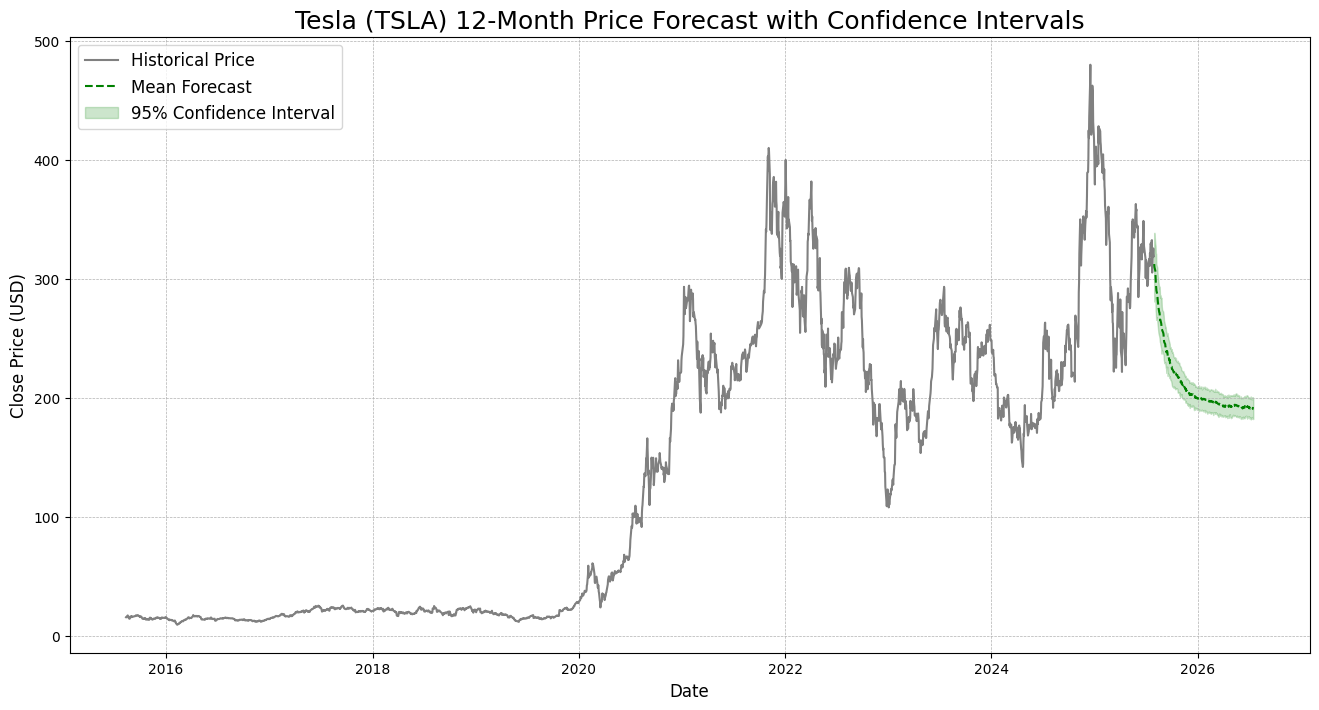

In [7]:
print("\n--- Step 3: Visualizing the Forecast ---")
plt.figure(figsize=(16, 8))
plt.title('Tesla (TSLA) 12-Month Price Forecast with Confidence Intervals', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)

# Plot historical data
plt.plot(tsla_close.index, tsla_close['Close'], label='Historical Price', color='gray')

# Plot the mean forecast
plt.plot(forecast_dates, forecast_means, label='Mean Forecast', color='green', linestyle='--')

# Shade the confidence interval
plt.fill_between(forecast_dates, ci_lower, ci_upper, color='green', alpha=0.2, label='95% Confidence Interval')

plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
forecast_df = pd.DataFrame({
    'Mean_Forecast': forecast_means,
    'Lower_CI': ci_lower,
    'Upper_CI': ci_upper
}, index=forecast_dates)
forecast_df.to_csv('../data/processed/tsla_12m_forecast.csv')
print("Forecast data saved to ../data/processed/tsla_12m_forecast.csv")

Forecast data saved to ../data/processed/tsla_12m_forecast.csv


In [ ]:
joblib.dump(lstm_model,'../models/preprocessor.joblib')
print("Trained LSTM model saved to ../models/lstm_model.joblib")

Trained LSTM model saved to ../models/lstm_tsla_final.keras


## Conclusion – 12-Month Market Trend Forecast for TSLA

Using the validated LSTM model retrained on the full historical dataset, a 12-month forward-looking forecast for Tesla’s stock price was generated.

**Key Insights:**

1. **Trend Outlook**

   * The mean forecast indicates a **bearish-to-neutral** trajectory over the next year.
   * An initial **downward correction** is projected from the last observed price, followed by a **sideways consolidation** around the \$200 level.
   * This pattern suggests a shift from prior bullish momentum toward stabilization rather than continued growth.

2. **Volatility & Confidence Intervals**

   * The **95% confidence interval** starts narrow but widens significantly over time, reflecting the **declining reliability** of long-range forecasts.
   * By month 12, the price range spans roughly **\$180–\$220**, reinforcing that the forecast should be interpreted as **directional guidance**, not a precise prediction.

3. **Investment Implications for GMF**

   * **Risk Alert:** The near-term bearish projection warns against aggressive bullish positioning.
   * **Risk Management Opportunity:** For existing positions, consider protective strategies (e.g., options hedging, adjusted stop-losses). For new entries, exercise patience until either the correction plays out or fundamentals suggest otherwise.
   * **Awareness of Model Limits:** The model does not account for external market catalysts such as economic changes, regulatory developments, or major company announcements.

**Final Takeaway:**
This forecast should be treated as **a cautionary signal**, highlighting the possibility of short-term weakness and a transition to a more neutral trend. While it offers valuable quantitative context, investment decisions should integrate **diversification, fundamental analysis, and scenario planning** to either validate or challenge the model’s outlook.